In [1]:
from SimPEG import *
from SimPEG.EM.Static import DC
%pylab inline

/Users/sgkang/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': True})
# matplotlib.rcParams.update({'font.size': 16, 'font.family': 'arial'})

# 1D DC inversion of Schlumberger array

This is an example for 1D DC Sounding inversion. This 1D inversion usually use analytic foward modeling, which is efficient. However, we choose different approach to show flexibility in geophysical inversion through mapping. Here mapping ($M$)indicates transformation of our model to a different space:

$$
    \mathbf{m} = M(\mathbf{\sigma})
$$

Now we consider a transformation, which maps 3D conductivity model to 1D layer model. That is, 3D distribution of conducitivity can be parameterized as 1D model. Once we can compute derivative of this transformation, we can change our model space, based on the transformation. 

Following example will show you how user can implement this set up with 1D DC inversion example. Note that we have 3D forward modeling mesh.

## Step1: Generate mesh

In [3]:
cs = 25.
npad = 11
hx = [(cs,npad, -1.3),(cs,41),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,17),(cs,npad, 1.3)]
hz = [(cs,npad, -1.3),(cs,20)]

In [4]:
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')

In [5]:
def plotLayer(sig, LocSigZ, xscale='log', ax=None, showlayers=False, xlim=None,**kwargs):
    """
        Plot Conductivity model for the layered earth model
    """
    sigma = np.repeat(sig, 2, axis=0)
    z = np.repeat(LocSigZ[1:], 2, axis=0)
    z = np.r_[LocSigZ[0], z, LocSigZ[-1]]

    if xlim == None:
        sig_min = sig.min()*0.5
        sig_max = sig.max()*2
    else:
        sig_min, sig_max = xlim

    if xscale == 'linear' and sig.min() == 0.:
        if xlim == None:
            sig_min = -sig.max()*0.5
            sig_max = sig.max()*2

    if ax==None:
        plt.xscale(xscale)
        plt.xlim(sig_min, sig_max)
        plt.ylim(z.min(), z.max())
        plt.xlabel('Conductivity (S/m)', fontsize = 14)
        plt.ylabel('Depth (m)', fontsize = 14)
        plt.ylabel('Depth (m)', fontsize = 14)
        if showlayers == True:
            for locz in LocSigZ:
                plt.plot(np.linspace(sig_min, sig_max, 100), np.ones(100)*locz, 'b--', lw = 0.5)
        return plt.plot(sigma, z, 'k-', **kwargs)

    else:
        ax.set_xscale(xscale)
        ax.set_xlim(sig_min, sig_max)
        ax.set_ylim(z.min(), z.max())
        ax.set_xlabel('Conductivity (S/m)', fontsize = 14)
        ax.set_ylabel('Depth (m)', fontsize = 14)
        if showlayers == True:
            for locz in LocSigZ:
                ax.plot(np.linspace(sig_min, sig_max, 100), np.ones(100)*locz, 'b--', lw = 0.5)
        return ax.plot(sigma, z, 'k-', **kwargs)

## Step2: Generating model and mapping (1D to 3D)

In [6]:
mapping = Maps.ExpMap(mesh)*Maps.Vertical1DMap(mesh)
siglay1 = 1./(100.)
siglay2 = 1./(500.)
sighalf = 1./(100.)
sigma = np.ones(mesh.nCz)*siglay1
sigma[mesh.vectorCCz<=-100.] = siglay2
sigma[mesh.vectorCCz<-150.] = sighalf
mtrue = np.log(sigma)

/Users/sgkang/Projects/simpeg/SimPEG/Maps.py:1289: FutureWarning: `Vertical1DMap` is deprecated and will be removed in futureversions. Use `SurjectVertical1D` instead
  FutureWarning)


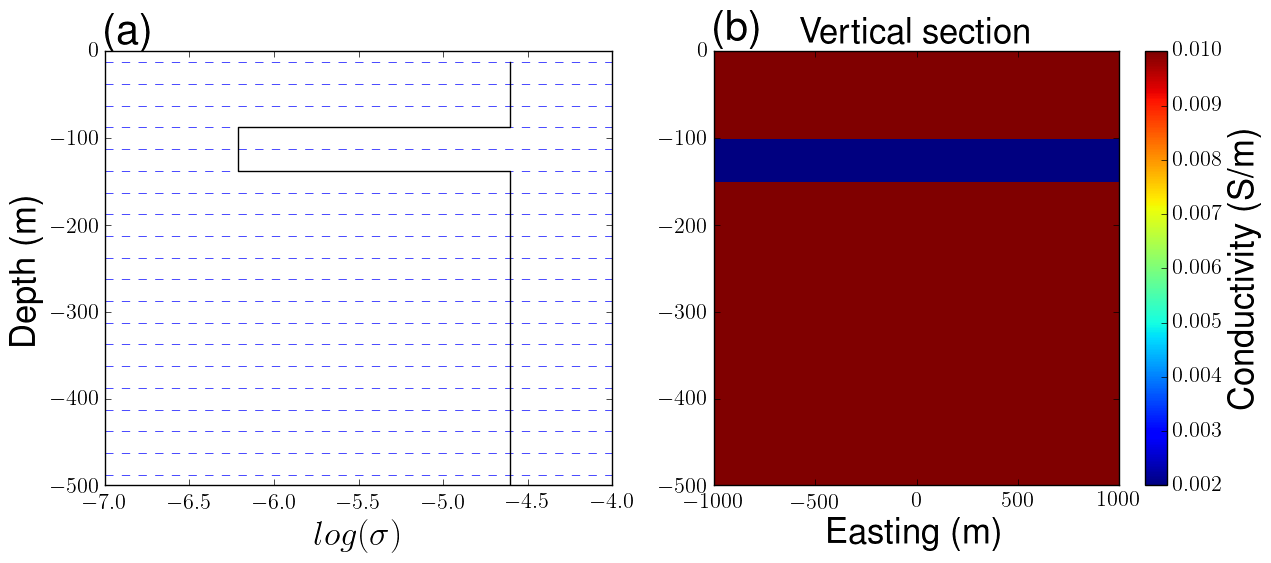

In [7]:
fig, ax = plt.subplots(1,2, figsize = (18*0.8, 7*0.8))
plotLayer(np.log(sigma), mesh.vectorCCz, 'linear', showlayers=True, ax = ax[0])
ax[0].invert_xaxis()
ax[0].set_ylim(-500, 0)
ax[0].set_xlim(-7, -4)
ax[0].set_xlabel('$log(\sigma)$', fontsize = 25)
ax[0].set_ylabel('Depth (m)', fontsize = 25)
ax[0].text(-7., 10., '(a)', fontsize = 30)
dat = mesh.plotSlice((mapping*mtrue), normal='Y', ind = 9, ax = ax[1])
cb = plt.colorbar(dat[0], ax =ax[1])
ax[1].set_title("Vertical section", fontsize = 25)
cb.set_label("Conductivity (S/m)", fontsize = 25)
ax[1].set_xlabel('Easting (m)', fontsize = 25)
ax[1].set_ylabel(' ', fontsize = 25)
ax[1].set_xlim(-1000., 1000.)
ax[1].set_ylim(-500., 0.)
ax[1].text(-1000., 13., '(b)', fontsize = 30)
fig.savefig('mappingDC.png', dpi=200)

In [8]:
# fig, ax = plt.subplots(1,1, figsize = (7, 5))
# dat = mesh.plotSlice((mapping*mtrue), normal='Y', ind = 9, ax = ax)
# cb = plt.colorbar(dat[0], ax =ax)
# ax.set_title("Vertical section", fontsize = 16)
# cb.set_label("Conductivity (S/m)", fontsize = 16)
# ax.set_xlabel('Easting (m)', fontsize = 16)
# ax.set_ylabel('Depth (m)', fontsize = 16)
# ax.set_xlim(-1000., 1000.)
# ax.set_ylim(-500., 0.)
# ax.text(-1000., 20., '(b)', fontsize = 20)
# fig.savefig('cond3d.png', dpi=200)

## Step3: Design survey: Schulumberger array

<img src="http://www.landrinstruments.com/_/rsrc/1271695892678/home/ultra-minires/additional-information-1/schlumberger-soundings/schlum%20array.JPG"> </img>

### $$ \rho_a = \frac{V}{I}\pi\frac{b(b+a)}{a}$$

#### Let $b=na$, then we rewrite above equation as:

### $$ \rho_a = \frac{V}{I}\pi na(n+1)$$

#### Since AB/2 can be a good measure for depth of investigation, we express 

### $$AB/2 = \frac{(2n+1)a}{2}$$

In [9]:
ntx = 16

In [10]:
xtemp_txP = np.arange(ntx)*(25.)-500.
xtemp_txN = -xtemp_txP
ytemp_tx = np.zeros(ntx)
xtemp_rxP = -50.
xtemp_rxN = 50.
ytemp_rx = 0.
abhalf = abs(xtemp_txP-xtemp_txN)*0.5
a = xtemp_rxN-xtemp_rxP
b = ((xtemp_txN-xtemp_txP)-a)*0.5

(-0.2, 0.6)

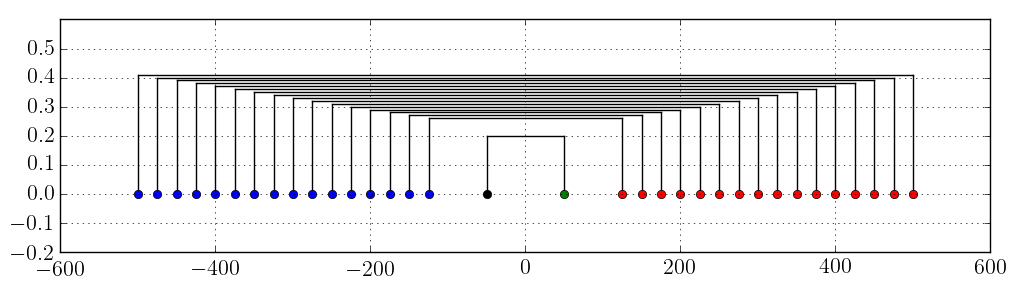

In [11]:
fig, ax = plt.subplots(1,1, figsize = (12,3))
for i in range(ntx):
    ax.plot(np.r_[xtemp_txP[i], xtemp_txP[i]], np.r_[0., 0.4-0.01*(i-1)], 'k-', lw = 1)
    ax.plot(np.r_[xtemp_txN[i], xtemp_txN[i]], np.r_[0., 0.4-0.01*(i-1)], 'k-', lw = 1)
    ax.plot(xtemp_txP[i], ytemp_tx[i], 'bo')
    ax.plot(xtemp_txN[i], ytemp_tx[i], 'ro')
    ax.plot(np.r_[xtemp_txP[i], xtemp_txN[i]], np.r_[0.4-0.01*(i-1), 0.4-0.01*(i-1)], 'k-', lw = 1)    

ax.plot(np.r_[xtemp_rxP, xtemp_rxP], np.r_[0., 0.2], 'k-', lw = 1)
ax.plot(np.r_[xtemp_rxN, xtemp_rxN], np.r_[0., 0.2], 'k-', lw = 1)
ax.plot(xtemp_rxP, ytemp_rx, 'ko')
ax.plot(xtemp_rxN, ytemp_rx, 'go')
ax.plot(np.r_[xtemp_rxP, xtemp_rxN], np.r_[0.2, 0.2], 'k-', lw = 1)    

ax.grid(True)    
ax.set_ylim(-0.2,0.6)
# ax.set_xlim(-600,600)

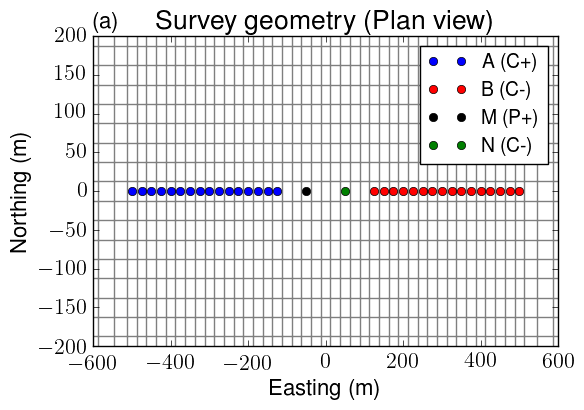

In [12]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.plot(xtemp_txP, ytemp_tx, 'bo')
ax.plot(xtemp_txN, ytemp_tx, 'ro')
ax.plot(xtemp_rxP, ytemp_rx, 'ko')
ax.plot(xtemp_rxN, ytemp_rx, 'go')
ax.legend(('A (C+)', 'B (C-)', 'M (P+)', 'N (C-)'), fontsize = 14)
mesh.plotSlice(np.log10(mapping*mtrue), grid=True, ax = ax, pcolorOpts={'cmap':'binary'})
ax.set_xlim(-600, 600)
ax.set_ylim(-200, 200)
ax.set_title('Survey geometry (Plan view)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.text(-600, 210, '(a)', fontsize = 16)
fig.savefig('DCsurvey.png', dpi = 200)

We generate tx and rx lists:

In [13]:
srclist = []
for i in range(ntx):    
    rx = DC.Rx.Dipole(np.r_[xtemp_rxP, ytemp_rx, -12.5], np.r_[xtemp_rxN, ytemp_rx, -12.5])
    locA = np.r_[xtemp_txP[i], ytemp_tx[i], -12.5]
    locB = np.r_[xtemp_txN[i], ytemp_tx[i], -12.5]
    src = DC.Src.Dipole([rx], locA, locB)
    srclist.append(src)

## Step4: Set up problem and pair with survey

In [16]:
survey = DC.Survey(srclist)
problem = DC.Problem3D_CC(mesh, sigmaMap=mapping)
problem.pair(survey)
try:
    from pymatsolver import PardisoSolver
    problem.Solver = PardisoSolver
except Exception, e:
    problem.Solver = SolverLU    

## Step5: Run survey.dpred to comnpute syntetic data

In [17]:
%%time
data = survey.dpred(mtrue)

CPU times: user 4.37 s, sys: 305 ms, total: 4.67 s
Wall time: 3.14 s


$$ \rho_a = \frac{V}{I}\pi\frac{b(b+a)}{a}$$

To make synthetic example you can use survey.makeSyntheticData, which generates related setups

In [18]:
survey.makeSyntheticData(mtrue,std=0.01,force=True)

array([ 0.01885848,  0.02078099,  0.02382253,  0.02646207,  0.0303115 ,
        0.03414019,  0.03905606,  0.04498643,  0.05426674,  0.06247706,
        0.07438956,  0.09038739,  0.11543814,  0.14207979,  0.1916431 ,
        0.27327761])

(-500.0, 0.0)

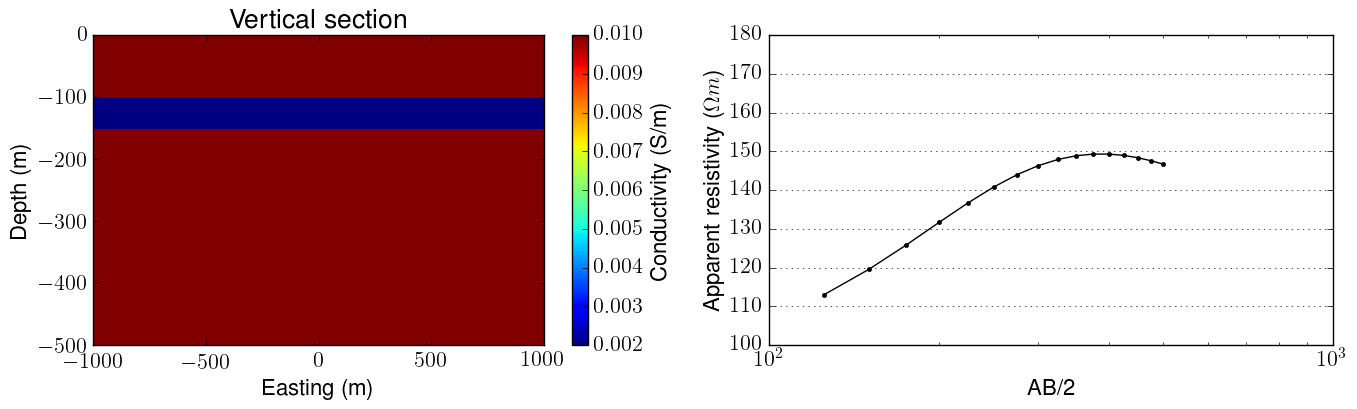

In [19]:
appres = data*np.pi*b*(b+a)/a
appres_obs = survey.dobs*np.pi*b*(b+a)/a
fig, ax = plt.subplots(1,2, figsize = (16, 4))
ax[1].semilogx(abhalf, appres, 'k.-')
ax[1].set_xscale('log')
ax[1].set_ylim(100., 180.)
ax[1].set_xlabel('AB/2')
ax[1].set_ylabel('Apparent resistivity ($\Omega m$)')
ax[1].grid(True)
# ax[1].text(100, 183, '(c)', fontsize = 16)
# ax[1].legend(('Observed', 'Predicted'), loc = 1)

dat = mesh.plotSlice((mapping*mtrue), normal='Y', ind = 9, ax = ax[0])
cb = plt.colorbar(dat[0], ax =ax[0])
ax[0].set_title("Vertical section")
cb.set_label("Conductivity (S/m)")
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlim(-1000., 1000.)
ax[0].set_ylim(-500., 0.)
# ax[0].text(-1000, 20, '(b)')
# fig.savefig('DCfwd.png', dpi=200)

## Step6: Run inversion

In [20]:
regmesh = Mesh.TensorMesh([31])

In [21]:
dmis = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.Tikhonov(regmesh)
opt = Optimization.InexactGaussNewton(maxIter=7,tolX=1e-15)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1e1)
betaSched = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaSched])

In [22]:
m0 = np.log(np.ones(mapping.nP)*sighalf)
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.00e+02  6.29e+03  0.00e+00  6.29e+03    8.84e+03      0              
   1  7.00e+02  4.03e+02  1.53e-01  5.10e+02    2.65e+03      0              
   2  1.40e+02  1.64e+02  1.53e-01  1.85e+02    4.78e+02      0              
   3  1.40e+02  9.18e+01  4.08e-01  1.49e+02    7.23e+01      0              
   4  2.80e+01  9.44e+01  3.88e-01  1.05e+02    2.46e+02      0              
   5  2.80e+01  3.43e+01  1.44e+00  7.45e+01    9.32e+01    

In [25]:
# matplotlib.rcParams.update({'font.size': 14, 'text.usetex': True, 'font.family': 'arial'})

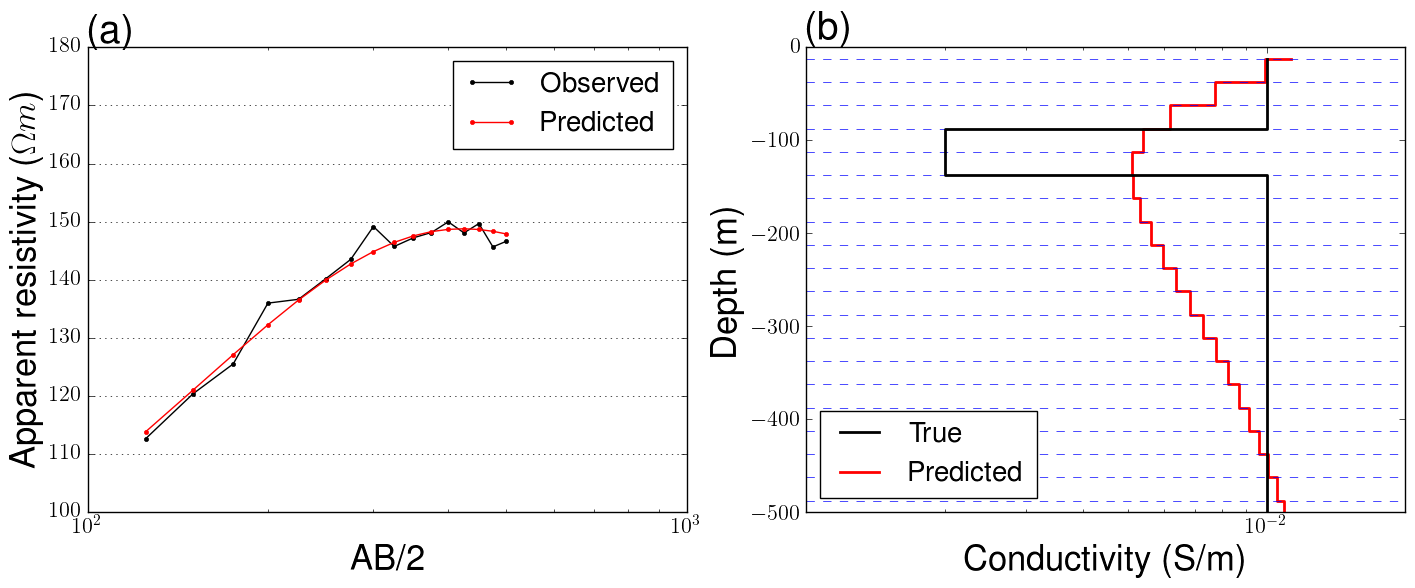

In [26]:
appres = data*np.pi*b*(b+a)/a
appres_obs = survey.dobs*np.pi*b*(b+a)/a
appres_pred = invProb.dpred*np.pi*b*(b+a)/a
fig, ax = plt.subplots(1,2, figsize = (17, 6))
ax[0].plot(abhalf, appres_obs, 'k.-')
ax[0].plot(abhalf, appres_pred, 'r.-')
ax[0].set_xscale('log')
ax[0].set_ylim(100., 180.)
ax[0].set_xlabel('AB/2', fontsize=25)
ax[0].set_ylabel('Apparent resistivity ($\Omega m$)', fontsize=25)
ax[0].grid(True)
ax[0].legend(('Observed', 'Predicted'), loc = 1, fontsize=20)
ax[0].text(100., 181, '(a)', fontsize = 28)
ax[1].plot(1., 1., 'k', lw = 2)
ax[1].plot(1., 1., 'r', lw = 2)
ax[1].legend(('True', 'Predicted'), loc = 3, fontsize = 20)
plotLayer((np.exp(mopt)), mesh.vectorCCz, 'log', ax = ax[1], **{'lw':2, 'color':'r'})
plotLayer((np.exp(mtrue)), mesh.vectorCCz, 'log', showlayers=True, ax = ax[1], **{'lw':2})
ax[1].set_ylim(-500, 0)
ax[1].set_xlabel('Conductivity (S/m)', fontsize = 25)
ax[1].set_ylabel('Depth (m)', fontsize = 25)
ax[1].text(1e-3, 10., '(b)', fontsize = 28)
# fig.savefig('obspredDC.png', dpi=200)

In [27]:
# fig, ax = plt.subplots(1,1, figsize = (7.5, 7))
# ax.plot(1., 1., 'k', lw = 2)
# ax.plot(1., 1., 'r', lw = 2)
# ax.legend(('True', 'Predicted'), loc = 3, fontsize = 16)
# Utils1D.plotLayer((np.exp(mopt)), mesh.vectorCCz, 'log', ax = ax, **{'lw':2, 'color':'r'})
# Utils1D.plotLayer((np.exp(mtrue)), mesh.vectorCCz, 'log', showlayers=True, ax = ax, **{'lw':2})
# ax.set_ylim(-500, 0)
# ax.set_xlabel('Conductivity (S/m)', fontsize = 20)
# ax.set_ylabel('Depth (m)', fontsize = 20)
# ax.text(1e-3, 10., '(b)', fontsize = 30)
# fig.savefig('obspred_dc1d_mod.png', dpi=200)